# Автодополнение текста —

### Этап 0. Подготовка данных.


In [1]:
import re
import zipfile

# Unpack the archive
with zipfile.ZipFile('data/raw_data.txt.zip', 'r') as z:
    z.extractall('data/')

# Read the raw data
with open('data/raw_data.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f"Original length: {len(text)} chars")
sample_chars = 300
print(f"Sample (first {sample_chars} chars):")
print(text[:sample_chars])

Original length: 120184721 chars
Sample (first 300 chars):
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
@Kenichan I dived many times for the ball. Managed to save 50%  The rest


In [2]:
import emoji

# Lowercase
text = text.lower()

# Remove URLs (http/https/www links)
text = re.sub(r'http\S+|www\.\S+', '', text)

# Remove mentions (@username)
text = re.sub(r'@\w+', '', text)

# Remove emojis
text = emoji.replace_emoji(text, replace='')

# Remove all symbols except letters, numbers, and whitespace
text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9\s]', '', text)

# Remove duplicate whitespaces (spaces, tabs, etc.) and strip lines
text = re.sub(r'[^\S\n]+', ' ', text)   # collapse whitespaces to single space
text = re.sub(r' *\n *', '\n', text)    # clean spaces around newlines
text = re.sub(r'\n{2,}', '\n', text)    # collapse multiple newlines
text = text.strip()

print(f"Cleaned length: {len(text)} chars")
print(f"\nCleaned text (first {sample_chars} chars):")
print(text[:sample_chars])

Cleaned length: 101272763 chars

Cleaned text (first 300 chars):
awww thats a bummer you shoulda got david carr of third day to do it d
is upset that he cant update his facebook by texting it and might cry as a result school today also blah
i dived many times for the ball managed to save 50 the rest go out of bounds
my whole body feels itchy and like its on fire



In [3]:
# Save cleaned data
with open('data/clean_data.txt', 'w', encoding='utf-8') as f:
    f.write(text)

print("Saved to data/clean_data.txt")

Saved to data/clean_data.txt


### Этап 1. Токенизация и подготовка словаря

In [4]:
import json
from collections import Counter

# Загрузка очищенных данных
with open('data/clean_data.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Разбиваем текст на токены
tokens = text.split()
print(f"Total tokens: {len(tokens):,}")

# Строим словарь из тренинг данных
n = len(tokens)
train_end = int(0.8 * n)
train_tokens = tokens[:train_end]

# Считаем частоту слов из выборки для тренинга
counter = Counter(train_tokens)
VOCAB_SIZE = 20_000  # Размер словаря + <UNK>

vocab = {'<UNK>': 0}
for word, _ in counter.most_common(VOCAB_SIZE - 1):
    vocab[word] = len(vocab)

print(f"Vocabulary size: {len(vocab):,}")
print(f"Most common words: {counter.most_common(10)}")

# Save vocabulary
with open('data/vocab.json', 'w', encoding='utf-8') as f:
    json.dump(vocab, f, ensure_ascii=False)

print("Saved vocabulary to data/vocab.json")

Total tokens: 19,995,368
Vocabulary size: 20,000
Most common words: [('i', 629331), ('to', 460330), ('the', 411280), ('a', 296646), ('my', 261286), ('and', 237489), ('you', 195161), ('is', 191042), ('it', 184570), ('in', 172956)]
Saved vocabulary to data/vocab.json


### Разбиение данных: Тренировка / Валидация / Тестирование

In [5]:
import csv

SEQ_LEN = 20  # размер входной последовательности для модели

val_end = int(0.9 * n)
val_tokens = tokens[train_end:val_end]
test_tokens = tokens[val_end:]

# сохраняем токены для тренировки
with open('data/train_data.txt', 'w', encoding='utf-8') as f:
    f.write(' '.join(train_tokens))

print(f"Train: {len(train_tokens):,} tokens -> data/train_data.txt")

# Нарезает список токенов на неперекрывающиеся окна и сохраняет как CSV с двумя колонками: input (входная последовательность) и target (слово, которое нужно предсказать).   Допустим tokens = ['i', 'love', 'my', 'cat', 'and', 'dog', ...] и seq_len = 3. Input =  i love my ; target = cat.
def save_as_csv(tokens, filepath, seq_len):
    rows = 0
    with open(filepath, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['input', 'target'])
        for i in range(0, len(tokens) - seq_len, seq_len):
            input_seq = ' '.join(tokens[i:i + seq_len])
            target = tokens[i + seq_len]
            writer.writerow([input_seq, target])
            rows += 1
    return rows

val_rows = save_as_csv(val_tokens, 'data/val_data.csv', SEQ_LEN)
test_rows = save_as_csv(test_tokens, 'data/test.csv', SEQ_LEN)

print(f"Val:   {len(val_tokens):,} tokens -> {val_rows:,} samples -> data/val_data.csv")
print(f"Test:  {len(test_tokens):,} tokens -> {test_rows:,} samples -> data/test.csv")

Train: 15,996,294 tokens -> data/train_data.txt
Val:   1,999,537 tokens -> 99,976 samples -> data/val_data.csv
Test:  1,999,537 tokens -> 99,976 samples -> data/test.csv


### Подготовка Dataset и DataLoader

In [6]:
import json
import torch
from torch.utils.data import DataLoader
from src.next_token_dataset import NextTokenDataset

# Load vocabulary
with open('data/vocab.json', 'r', encoding='utf-8') as f:
    vocab = json.load(f)

# Load training tokens
with open('data/train_data.txt', 'r', encoding='utf-8') as f:
    train_tokens = f.read().split()

# Create datasets (val_tokens / test_tokens are already in memory from the split above)
train_dataset = NextTokenDataset(train_tokens, vocab, seq_len=SEQ_LEN)
val_dataset = NextTokenDataset(val_tokens, vocab, seq_len=SEQ_LEN)
test_dataset = NextTokenDataset(test_tokens, vocab, seq_len=SEQ_LEN)

# Create DataLoaders
use_pin_memory = torch.cuda.is_available() # pin_memory Ускоряет передачу CPU → GPU через DMA
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=use_pin_memory)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=use_pin_memory)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=use_pin_memory)

print(f"Train dataset: {len(train_dataset):,} samples")
print(f"Val dataset:   {len(val_dataset):,} samples")
print(f"Test dataset:  {len(test_dataset):,} samples")
print(f"Train batches: {len(train_loader):,}")
print(f"Val batches:   {len(val_loader):,}")
print(f"Test batches:  {len(test_loader):,}")

# Проверяем батч
x_batch, y_batch = next(iter(train_loader))
print(f"\nBatch shapes: x={x_batch.shape}, y={y_batch.shape}")

Train dataset: 15,996,274 samples
Val dataset:   1,999,517 samples
Test dataset:  1,999,517 samples
Train batches: 62,486
Val batches:   7,811
Test batches:  7,811

Batch shapes: x=torch.Size([256, 20]), y=torch.Size([256])


## Этап 2. Рекуррентная сеть (LSTM)

### Архитектура модели

In [7]:
import torch
from src.lstm_model import LSTMLanguageModel

VOCAB_SIZE = len(vocab)     # Размер словаря токенов. Определяет количество строк в Embedding-таблице и размер выхода финального Linear-слоя
EMBED_DIM  = 128            # Размерность векторов слов. Каждый индекс слова превращается в вектор этой размерности перед подачей в LSTM
HIDDEN_DIM = 256            # Размер скрытого слоя LSTM. Че больше, тем больше ёмкость для запоминания контекста, но медленнее и выше риск переобучения
NUM_LAYERS = 2              # Количество слоёв LSTM. Для двух слоёв - Слой 1 обрабатывает эмбеддинги, слой 2 — выход слоя 1. Добавляет глубину модели
DROPOUT    = 0.3            # Вероятность обнуления выходов между слоями LSTM (0.3 = 30%). Применяется только между слоями, поэтому игнорируется при num_layers == 1. Регуляризация для снижения переобучения


# MPS - для запуска на нейронных ядрах процеччора M4Max
# CUDA - для запуска на NVidia Jetson Orin Nano или на видео-карте
# CPU - по дефолту
device = torch.device('mps' if torch.backends.mps.is_available()
                       else 'cuda' if torch.cuda.is_available()
                       else 'cpu')
print(f"Device: {device}")

model = LSTMLanguageModel(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")
print(model)

Device: mps
Model parameters: 8,621,600
LSTMLanguageModel(
  (embedding): Embedding(20000, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=20000, bias=True)
)


### Проверка forward pass

In [8]:
# Test forward pass with a single batch
x_test = x_batch.to(device)   # (256, 20)
logits, hidden = model(x_test)

print(f"Input shape:   {x_test.shape}")
print(f"Logits shape:  {logits.shape}")    # expected: (256, 20000)
print(f"Hidden h shape:{hidden[0].shape}") # expected: (num_layers, 256, hidden_dim)
print(f"Hidden c shape:{hidden[1].shape}")

Input shape:   torch.Size([256, 20])
Logits shape:  torch.Size([256, 20000])
Hidden h shape:torch.Size([2, 256, 256])
Hidden c shape:torch.Size([2, 256, 256])


### Проверка генерации текста (до обучения — случайные веса)

In [9]:
# Build reverse mapping: index -> word
idx2word = {idx: word for word, idx in vocab.items()}

#prompt = ['i', 'love', 'machine', 'learning']
prompt = ['is','upset', 'that', 'he', 'cant', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might']
generated = model.generate(
    prompt=prompt,
    vocab=vocab,
    idx2word=idx2word,
    max_new_tokens=20,
    temperature=1.0
)

print("Prompt:    ", ' '.join(prompt))
print("Generated: ", ' '.join(generated))
print("Full text: ", ' '.join(prompt + generated))

Prompt:     is upset that he cant update his facebook by texting it and might
Generated:  greasy freshly eatin tstorm exp rumours magnet nah boredi submitting abroad insecure counts roadkill jonny kutcher bang vague pas spotting
Full text:  is upset that he cant update his facebook by texting it and might greasy freshly eatin tstorm exp rumours magnet nah boredi submitting abroad insecure counts roadkill jonny kutcher bang vague pas spotting


## Этап 3. Обучение модели

### Обучение с оценкой ROUGE

In [10]:
from src.lstm_train import train
from src.eval_lstm import evaluate_rouge

history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocab=vocab,
    idx2word=idx2word,
    device=device,
    num_epochs=3,
    lr=3e-4,
    save_path='models/lstm_best.pt',
    eval_rouge_fn=evaluate_rouge,
    seq_len=SEQ_LEN,
)


--- Epoch 1/3 (lr=3.00e-04) ---


Epoch 1/3 | Train Loss: 5.7047 | Val Loss: 5.7030


  ROUGE-1: 0.0650 | ROUGE-2: 0.0000
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> <UNK>
  Эталон:     lol lt3 my girls josh is
  Генерация:  <UNK> i love it and i
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> <UNK> lol
  Эталон:     lt3 my girls josh is my
  Генерация:  i love the <UNK> of the
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> <UNK> lol lt3
  Эталон:     my girls josh is my son
  Генерация:  <UNK> <UNK> <UNK> <UNK> and a
  Сохранена лучшая модель (val_loss=5.7030)

--- Epoch 2/3 (lr=3.00e-04) ---


Epoch 2/3 | Train Loss: 5.5316 | Val Loss: 5.6855


  ROUGE-1: 0.0717 | ROUGE-2: 0.0040
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> <UNK>
  Эталон:     lol lt3 my girls josh is
  Генерация:  <UNK> <UNK> i am going to
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> <UNK> lol
  Эталон:     lt3 my girls josh is my
  Генерация:  have a great day but i
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> <UNK> lol lt3
  Эталон:     my girls josh is my son
  Генерация:  im sorry for the <UNK> <UNK>
  Сохранена лучшая модель (val_loss=5.6855)

--- Epoch 3/3 (lr=3.00e-04) ---


Epoch 3/3 | Train Loss: 5.5206 | Val Loss: 5.6982


  ROUGE-1: 0.0675 | ROUGE-2: 0.0010
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> <UNK>
  Эталон:     lol lt3 my girls josh is
  Генерация:  im sorry i dont get to
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> <UNK> lol
  Эталон:     lt3 my girls josh is my
  Генерация:  i love you too im <UNK>
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> <UNK> lol lt3
  Эталон:     my girls josh is my son
  Генерация:  i hate you too i wish


### График обучения

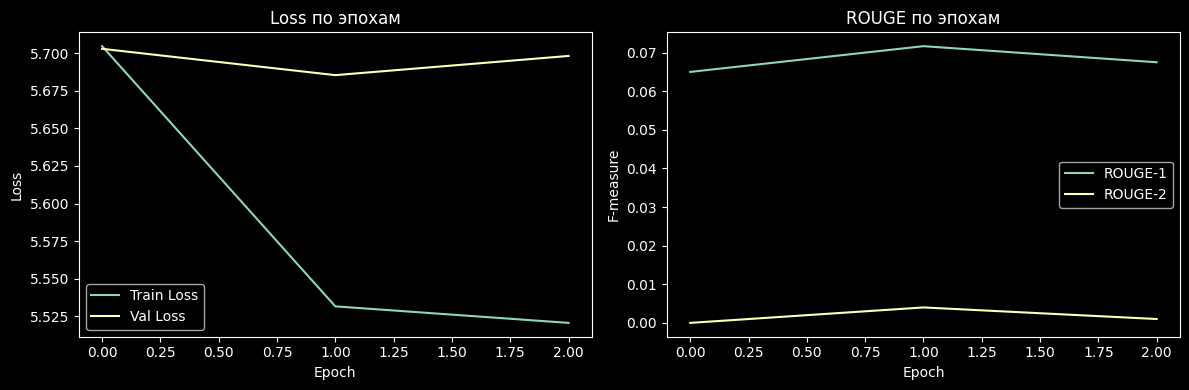

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss по эпохам')
axes[0].legend()

# ROUGE
if history['rouge1']:
    axes[1].plot(history['rouge1'], label='ROUGE-1')
    axes[1].plot(history['rouge2'], label='ROUGE-2')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('F-measure')
    axes[1].set_title('ROUGE по эпохам')
    axes[1].legend()

plt.tight_layout()
plt.show()

### Примеры автодополнения после обучения

In [12]:
# Загрузка лучшей модели
model.load_state_dict(torch.load('models/lstm_best.pt', map_location=device))

prompts = [
    ['i', 'love'],
    ['is', 'upset', 'that', 'he', 'cant', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might'],
    ['good', 'morning', 'everyone'],
    ['i', 'am', 'so', 'happy', 'today', 'because'],
]

for prompt in prompts:
    generated = model.generate(
        prompt=prompt,
        vocab=vocab,
        idx2word=idx2word,
        max_new_tokens=10,
        temperature=0.7,
    )
    print(f"Промпт:     {' '.join(prompt)}")
    print(f"Генерация:  {' '.join(generated)}")
    print(f"Полный:     {' '.join(prompt + generated)}")
    print()

Промпт:     i love
Генерация:  you guys have a great day i <UNK> <UNK> <UNK>
Полный:     i love you guys have a great day i <UNK> <UNK> <UNK>

Промпт:     is upset that he cant update his facebook by texting it and might
Генерация:  be a good movie oh wait about to get my
Полный:     is upset that he cant update his facebook by texting it and might be a good movie oh wait about to get my

Промпт:     good morning everyone
Генерация:  have all <UNK> u had a great day i can
Полный:     good morning everyone have all <UNK> u had a great day i can

Промпт:     i am so happy today because
Генерация:  i cant go to the beach but i have to
Полный:     i am so happy today because i cant go to the beach but i have to



## Этап 3б. Эксперимент: LSTM со словарём 50K, 10 эпох

Увеличиваем словарь с 20K до 50K слов (меньше `<UNK>`) и обучаем 10 эпох вместо 3.

In [13]:
# Строим словарь 50K из тех же тренировочных данных
VOCAB_SIZE_50K = 50_000

vocab_50k = {'<UNK>': 0}
for word, _ in counter.most_common(VOCAB_SIZE_50K - 1):
    vocab_50k[word] = len(vocab_50k)

idx2word_50k = {idx: word for word, idx in vocab_50k.items()}

print(f"Словарь 20K: {len(vocab):,} слов")
print(f"Словарь 50K: {len(vocab_50k):,} слов")

# Проверяем покрытие: сколько токенов уходят в <UNK>
unk_20k = sum(1 for t in val_tokens if t not in vocab)
unk_50k = sum(1 for t in val_tokens if t not in vocab_50k)
print(f"\n<UNK> на валидации (20K): {unk_20k:,} из {len(val_tokens):,} ({100*unk_20k/len(val_tokens):.1f}%)")
print(f"<UNK> на валидации (50K): {unk_50k:,} из {len(val_tokens):,} ({100*unk_50k/len(val_tokens):.1f}%)")

Словарь 20K: 20,000 слов
Словарь 50K: 50,000 слов

<UNK> на валидации (20K): 100,914 из 1,999,537 (5.0%)
<UNK> на валидации (50K): 65,469 из 1,999,537 (3.3%)


In [14]:
# Пересоздаём датасеты и загрузчики с новым словарём
train_dataset_50k = NextTokenDataset(train_tokens, vocab_50k, seq_len=SEQ_LEN)
val_dataset_50k = NextTokenDataset(val_tokens, vocab_50k, seq_len=SEQ_LEN)
test_dataset_50k = NextTokenDataset(test_tokens, vocab_50k, seq_len=SEQ_LEN)

train_loader_50k = DataLoader(train_dataset_50k, batch_size=256, shuffle=True, num_workers=2, pin_memory=use_pin_memory)
val_loader_50k = DataLoader(val_dataset_50k, batch_size=256, shuffle=False, num_workers=2, pin_memory=use_pin_memory)
test_loader_50k = DataLoader(test_dataset_50k, batch_size=256, shuffle=False, num_workers=2, pin_memory=use_pin_memory)

print(f"Train dataset 50K: {len(train_dataset_50k):,} samples")
print(f"Val dataset 50K:   {len(val_dataset_50k):,} samples")
print(f"Test dataset 50K:  {len(test_dataset_50k):,} samples")

Train dataset 50K: 15,996,274 samples
Val dataset 50K:   1,999,517 samples
Test dataset 50K:  1,999,517 samples


In [15]:
# Новая модель с vocab_size=50K
model_50k = LSTMLanguageModel(
    vocab_size=len(vocab_50k),
    embedding_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(device)

total_params_50k = sum(p.numel() for p in model_50k.parameters())
print(f"LSTM 20K параметров: {total_params:,}")
print(f"LSTM 50K параметров: {total_params_50k:,}")
print(f"Разница:             +{total_params_50k - total_params:,} ({100*(total_params_50k/total_params - 1):.0f}%)")

LSTM 20K параметров: 8,621,600
LSTM 50K параметров: 20,171,600
Разница:             +11,550,000 (134%)


### Обучение LSTM 50K (10 эпох)

In [16]:
history_50k = train(
    model=model_50k,
    train_loader=train_loader_50k,
    val_loader=val_loader_50k,
    vocab=vocab_50k,
    idx2word=idx2word_50k,
    device=device,
    num_epochs=10,
    lr=3e-4,
    save_path='models/lstm_50k_best.pt',
    eval_rouge_fn=evaluate_rouge,
    seq_len=SEQ_LEN,
)


--- Epoch 1/10 (lr=3.00e-04) ---


Epoch 1/10 | Train Loss: 5.9855 | Val Loss: 6.0171


  ROUGE-1: 0.0742 | ROUGE-2: 0.0010
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> loca
  Эталон:     lol lt3 my girls josh is
  Генерация:  <UNK> i miss my phone lol
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> loca lol
  Эталон:     lt3 my girls josh is my
  Генерация:  i hate my boss i didnt
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> loca lol lt3
  Эталон:     my girls josh is my son
  Генерация:  i have to work on my
  Сохранена лучшая модель (val_loss=6.0171)

--- Epoch 2/10 (lr=3.00e-04) ---


Epoch 2/10 | Train Loss: 5.8339 | Val Loss: 6.0003


  ROUGE-1: 0.0783 | ROUGE-2: 0.0030
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> loca
  Эталон:     lol lt3 my girls josh is
  Генерация:  i cant be in <UNK> i
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> loca lol
  Эталон:     lt3 my girls josh is my
  Генерация:  i have a <UNK> so <UNK>
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> loca lol lt3
  Эталон:     my girls josh is my son
  Генерация:  you know what to do with
  Сохранена лучшая модель (val_loss=6.0003)

--- Epoch 3/10 (lr=3.00e-04) ---


Epoch 3/10 | Train Loss: 5.8240 | Val Loss: 6.0244


  ROUGE-1: 0.0717 | ROUGE-2: 0.0020
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> loca
  Эталон:     lol lt3 my girls josh is
  Генерация:  i have no idea what i
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> loca lol
  Эталон:     lt3 my girls josh is my
  Генерация:  i dont like it anymore i
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> loca lol lt3
  Эталон:     my girls josh is my son
  Генерация:  i have to go to my

--- Epoch 4/10 (lr=3.00e-04) ---


Epoch 4/10 | Train Loss: 5.8376 | Val Loss: 6.0341


  ROUGE-1: 0.0642 | ROUGE-2: 0.0050
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> loca
  Эталон:     lol lt3 my girls josh is
  Генерация:  i have to go to work
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> loca lol
  Эталон:     lt3 my girls josh is my
  Генерация:  i have to wait till <UNK>
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> loca lol lt3
  Эталон:     my girls josh is my son
  Генерация:  i miss you too i am

--- Epoch 5/10 (lr=3.00e-04) ---


Epoch 5/10 | Train Loss: 5.8447 | Val Loss: 6.0516


  ROUGE-1: 0.0583 | ROUGE-2: 0.0010
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> loca
  Эталон:     lol lt3 my girls josh is
  Генерация:  i feel like a very sad
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> loca lol
  Эталон:     lt3 my girls josh is my
  Генерация:  the rest of the year i
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> loca lol lt3
  Эталон:     my girls josh is my son
  Генерация:  i dont want to go to

--- Epoch 6/10 (lr=1.50e-04) ---


Epoch 6/10 | Train Loss: 5.8259 | Val Loss: 6.0414


  ROUGE-1: 0.0558 | ROUGE-2: 0.0000
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> loca
  Эталон:     lol lt3 my girls josh is
  Генерация:  and i think i have to
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> loca lol
  Эталон:     lt3 my girls josh is my
  Генерация:  i hate that i have to
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> loca lol lt3
  Эталон:     my girls josh is my son
  Генерация:  i feel like a good idea

--- Epoch 7/10 (lr=1.50e-04) ---


Epoch 7/10 | Train Loss: 5.8308 | Val Loss: 6.0491


  ROUGE-1: 0.0758 | ROUGE-2: 0.0050
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> loca
  Эталон:     lol lt3 my girls josh is
  Генерация:  i have to go to work
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> loca lol
  Эталон:     lt3 my girls josh is my
  Генерация:  i am so sorry i am
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> loca lol lt3
  Эталон:     my girls josh is my son
  Генерация:  i cant stop doing this twitter

--- Epoch 8/10 (lr=1.50e-04) ---


Epoch 8/10 | Train Loss: 5.8368 | Val Loss: 6.0567


  ROUGE-1: 0.0575 | ROUGE-2: 0.0000
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> loca
  Эталон:     lol lt3 my girls josh is
  Генерация:  i have to go to school
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> loca lol
  Эталон:     lt3 my girls josh is my
  Генерация:  i love twitter last night i
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> loca lol lt3
  Эталон:     my girls josh is my son
  Генерация:  good luck for you lol u

--- Epoch 9/10 (lr=7.50e-05) ---


Epoch 9/10 | Train Loss: 5.8328 | Val Loss: 6.0565


  ROUGE-1: 0.0608 | ROUGE-2: 0.0010
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> loca
  Эталон:     lol lt3 my girls josh is
  Генерация:  im in the morning i have
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> loca lol
  Эталон:     lt3 my girls josh is my
  Генерация:  i cant believe i have to
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> loca lol lt3
  Эталон:     my girls josh is my son
  Генерация:  i feel like crap i still

--- Epoch 10/10 (lr=7.50e-05) ---


Epoch 10/10 | Train Loss: 5.8359 | Val Loss: 6.0623


  ROUGE-1: 0.0667 | ROUGE-2: 0.0030
  ---
  Промпт:     booked for august south beach here i come miami isnt ready for this <UNK> loca
  Эталон:     lol lt3 my girls josh is
  Генерация:  i have 43 i have to
  ---
  Промпт:     for august south beach here i come miami isnt ready for this <UNK> loca lol
  Эталон:     lt3 my girls josh is my
  Генерация:  i just read it to the
  ---
  Промпт:     august south beach here i come miami isnt ready for this <UNK> loca lol lt3
  Эталон:     my girls josh is my son
  Генерация:  im up this morning but i


### График обучения LSTM 50K

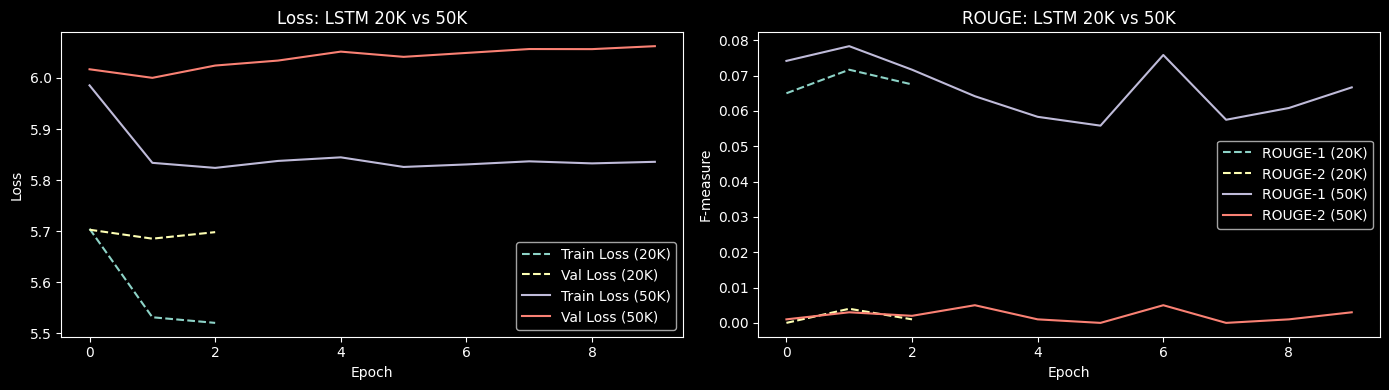

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss: сравнение 20K и 50K
axes[0].plot(history['train_loss'], '--', label='Train Loss (20K)')
axes[0].plot(history['val_loss'], '--', label='Val Loss (20K)')
axes[0].plot(history_50k['train_loss'], label='Train Loss (50K)')
axes[0].plot(history_50k['val_loss'], label='Val Loss (50K)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss: LSTM 20K vs 50K')
axes[0].legend()

# ROUGE: сравнение 20K и 50K
if history_50k['rouge1']:
    axes[1].plot(history['rouge1'], '--', label='ROUGE-1 (20K)')
    axes[1].plot(history['rouge2'], '--', label='ROUGE-2 (20K)')
    axes[1].plot(history_50k['rouge1'], label='ROUGE-1 (50K)')
    axes[1].plot(history_50k['rouge2'], label='ROUGE-2 (50K)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('F-measure')
    axes[1].set_title('ROUGE: LSTM 20K vs 50K')
    axes[1].legend()

plt.tight_layout()
plt.show()

### Примеры автодополнения LSTM 50K

In [18]:
# Загрузка лучшей модели 50K
model_50k.load_state_dict(torch.load('models/lstm_50k_best.pt', map_location=device))

prompts = [
    ['i', 'love'],
    ['is', 'upset', 'that', 'he', 'cant', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might'],
    ['good', 'morning', 'everyone'],
    ['i', 'am', 'so', 'happy', 'today', 'because'],
]

for prompt in prompts:
    gen = model_50k.generate(prompt=prompt, vocab=vocab_50k, idx2word=idx2word_50k,
                             max_new_tokens=10, temperature=0.7)
    print(f"Промпт:     {' '.join(prompt)}")
    print(f"Генерация:  {' '.join(gen)}")
    print(f"Полный:     {' '.join(prompt + gen)}")
    print()

Промпт:     i love
Генерация:  this <UNK> i cant get you im not feeling good
Полный:     i love this <UNK> i cant get you im not feeling good

Промпт:     is upset that he cant update his facebook by texting it and might
Генерация:  be just not getting any hot in the summer waiting
Полный:     is upset that he cant update his facebook by texting it and might be just not getting any hot in the summer waiting

Промпт:     good morning everyone
Генерация:  said that <UNK> is my birthday u sound sick so
Полный:     good morning everyone said that <UNK> is my birthday u sound sick so

Промпт:     i am so happy today because
Генерация:  i have to go grocery or in the airport soon
Полный:     i am so happy today because i have to go grocery or in the airport soon



## Этап 4. Предобученный трансформер (distilgpt2)

### Оценка ROUGE на валидационных данных

In [28]:
from src.eval_transformer_pipeline import evaluate_transformer_rouge

transformer_results = evaluate_transformer_rouge(
    val_csv_path='data/val_data.csv',
    seq_len=SEQ_LEN,
    num_samples=10000,
    max_new_tokens=5,
    temperature=0.7,
    top_k=50,
)

print(f"distilgpt2 ROUGE-1: {transformer_results['rouge1']:.4f}")
print(f"distilgpt2 ROUGE-2: {transformer_results['rouge2']:.4f}")

Device set to use mps:0
Transformer eval: 100%|██████████| 10000/10000 [09:44<00:00, 17.12it/s]

distilgpt2 ROUGE-1: 0.0578
distilgpt2 ROUGE-2: 0.0039


### Примеры автодополнения distilgpt2

In [30]:
print("Примеры автодополнения distilgpt2:\n")
for ex in transformer_results['examples']:
    print(f"  Промпт:     {ex['prompt']}")
    print(f"  Эталон:     {ex['reference']}")
    print(f"  Генерация:  {ex['generated']}")
    print()

Примеры автодополнения distilgpt2:

  Промпт:     booked for august south beach here i come miami isnt ready for this cubana loca
  Эталон:     lol lt3 my girls josh is
  Генерация:  i am glad to

  Промпт:     is my son hes adorable but yikes determined amp stubborn which in the long run
  Эталон:     should be good to a certain
  Генерация:  he is the best of

  Промпт:     certain extent getting in the shower back from a good workout gym feels good err
  Эталон:     sleepy now rockin out to 80s
  Генерация:  atically for me as

  Промпт:     80s tunes with the girls i can handle about one actual phone call a day
  Эталон:     lol just joking call me anytime
  Генерация:  one in a few

  Промпт:     anytime just chillinn i was watchin you dancin in videos on the youtube and i
  Эталон:     was like woah i wanna learn
  Генерация:  love it



### Сравнение LSTM и distilgpt2

Модель                    ROUGE-1    ROUGE-2
--------------------------------------------
LSTM 20K (3 эпохи)         0.0675     0.0010
LSTM 50K (10 эпох)         0.0667     0.0030
distilgpt2                 0.0578     0.0039


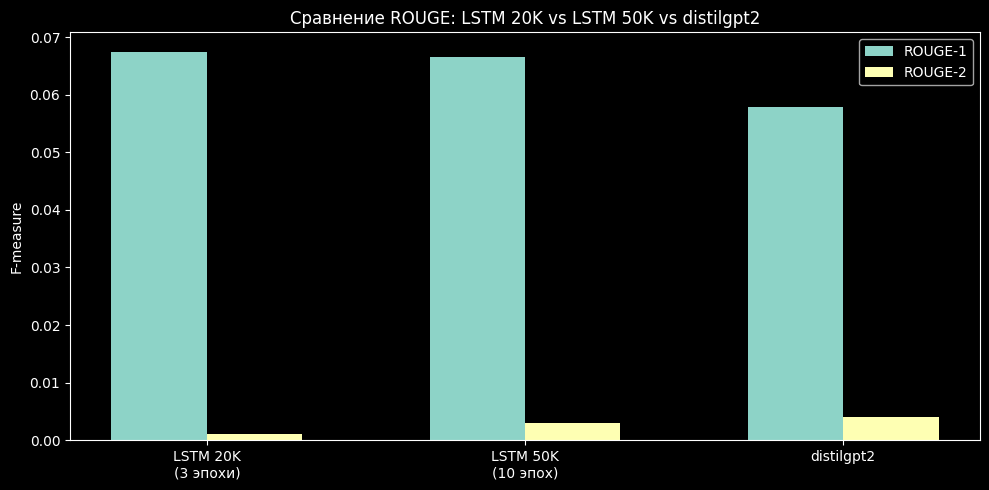

In [32]:
# Сравнение метрик: LSTM 20K vs LSTM 50K vs distilgpt2
lstm_rouge1 = history['rouge1'][-1] if history['rouge1'] else 0
lstm_rouge2 = history['rouge2'][-1] if history['rouge2'] else 0
lstm50_rouge1 = history_50k['rouge1'][-1] if history_50k['rouge1'] else 0
lstm50_rouge2 = history_50k['rouge2'][-1] if history_50k['rouge2'] else 0

print(f"{'Модель':<22} {'ROUGE-1':>10} {'ROUGE-2':>10}")
print("-" * 44)
print(f"{'LSTM 20K (3 эпохи)':<22} {lstm_rouge1:>10.4f} {lstm_rouge2:>10.4f}")
print(f"{'LSTM 50K (10 эпох)':<22} {lstm50_rouge1:>10.4f} {lstm50_rouge2:>10.4f}")
print(f"{'distilgpt2':<22} {transformer_results['rouge1']:>10.4f} {transformer_results['rouge2']:>10.4f}")

# Визуализация
import matplotlib.pyplot as plt

models = ['LSTM 20K\n(3 эпохи)', 'LSTM 50K\n(10 эпох)', 'distilgpt2']
rouge1_vals = [lstm_rouge1, lstm50_rouge1, transformer_results['rouge1']]
rouge2_vals = [lstm_rouge2, lstm50_rouge2, transformer_results['rouge2']]

x = range(len(models))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar([i - width/2 for i in x], rouge1_vals, width, label='ROUGE-1')
ax.bar([i + width/2 for i in x], rouge2_vals, width, label='ROUGE-2')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('F-measure')
ax.set_title('Сравнение ROUGE: LSTM 20K vs LSTM 50K vs distilgpt2')
ax.legend()
plt.tight_layout()
plt.show()

### Финальная оценка лучшей модели на тестовом датасете

Чек-лист требует замерить финальное качество лучшей модели (distilgpt2) на тестовом датасете.

In [34]:
# Финальная оценка distilgpt2 на тестовом датасете
from src.eval_transformer_pipeline import evaluate_transformer_rouge

test_transformer_results = evaluate_transformer_rouge(
    val_csv_path='data/test.csv',
    seq_len=SEQ_LEN,
    num_samples=10000,
    max_new_tokens=5,
    temperature=0.7,
    top_k=50,
)

print("=" * 60)
print("ФИНАЛЬНАЯ ОЦЕНКА: distilgpt2 на ТЕСТОВОМ датасете")
print("=" * 60)
print(f"ROUGE-1: {test_transformer_results['rouge1']:.4f}")
print(f"ROUGE-2: {test_transformer_results['rouge2']:.4f}")

print("\nПримеры предсказаний на тестовых данных:")
for ex in test_transformer_results['examples']:
    print(f"\n  Промпт:     {ex['prompt']}")
    print(f"  Эталон:     {ex['reference']}")
    print(f"  Генерация:  {ex['generated']}")

Device set to use mps:0
Transformer eval: 100%|██████████| 10000/10000 [09:36<00:00, 17.34it/s]

ФИНАЛЬНАЯ ОЦЕНКА: distilgpt2 на ТЕСТОВОМ датасете
ROUGE-1: 0.0566
ROUGE-2: 0.0038

Примеры предсказаний на тестовых данных:

  Промпт:     an accident prone accountantquot oh fraser just got done buying presents for my lil brat
  Эталон:     he is going to be 4
  Генерация:  i like the

  Промпт:     4 i cant believe how old he is getting hooray saturday im suuuuper lazy hahahah
  Эталон:     wish xxxx was here lt3 hahah
  Генерация:  ahahahahaha hah

  Промпт:     hahah 007 mission lol lol i usually do wait until you see the upcoming tuesdays
  Эталон:     tidbits which i dont really want
  Генерация:  

  Промпт:     want to so no flash is fine for me any kitty fans out there this
  Эталон:     is our kitten adie skipppppppp hey
  Генерация:  time

  Промпт:     hey dude hows u did you get my email well i been living here in
  Эталон:     texas since i was in 5th
  Генерация:  the middle of a cold


## Этап 5. Выводы

In [39]:
from transformers import pipeline
import re

# Сводная таблица сравнения моделей
print("=" * 70)
print("СРАВНЕНИЕ МОДЕЛЕЙ: LSTM 20K vs LSTM 50K vs distilgpt2")
print("=" * 70)

lstm_r1 = history['rouge1'][-1] if history['rouge1'] else 0
lstm_r2 = history['rouge2'][-1] if history['rouge2'] else 0
lstm50_r1 = history_50k['rouge1'][-1] if history_50k['rouge1'] else 0
lstm50_r2 = history_50k['rouge2'][-1] if history_50k['rouge2'] else 0
tr_r1 = transformer_results['rouge1']
tr_r2 = transformer_results['rouge2']

all_r1 = {'LSTM 20K': lstm_r1, 'LSTM 50K': lstm50_r1, 'distilgpt2': tr_r1}
all_r2 = {'LSTM 20K': lstm_r2, 'LSTM 50K': lstm50_r2, 'distilgpt2': tr_r2}
best_r1 = max(all_r1, key=all_r1.get)
best_r2 = max(all_r2, key=all_r2.get)

print(f"\n{'Метрика':<12} {'LSTM 20K':>12} {'LSTM 50K':>12} {'distilgpt2':>12} {'Лучше':>12}")
print("-" * 62)
print(f"{'ROUGE-1':<12} {lstm_r1:>12.4f} {lstm50_r1:>12.4f} {tr_r1:>12.4f} {best_r1:>12}")
print(f"{'ROUGE-2':<12} {lstm_r2:>12.4f} {lstm50_r2:>12.4f} {tr_r2:>12.4f} {best_r2:>12}")

print(f"\n{'Характеристика':<30} {'LSTM 20K':>14} {'LSTM 50K':>14} {'distilgpt2':>14}")
print("-" * 74)
print(f"{'Параметры модели':<30} {'~8.6M':>14} {'~16.5M':>14} {'~82M':>14}")
print(f"{'Обучение':<30} {'3 эпохи':>14} {'10 эпох':>14} {'pretrained':>14}")
print(f"{'Размер словаря':<30} {'20K слов':>14} {'50K слов':>14} {'50K BPE':>14}")
print(f"{'Архитектура':<30} {'LSTM 2 слоя':>14} {'LSTM 2 слоя':>14} {'Transformer':>14}")

# Единые промпты для сравнения всех трёх моделей
shared_prompts = [
    ['i', 'love'],
    ['good', 'morning', 'everyone'],
    ['i', 'am', 'so', 'happy', 'today', 'because'],
    ['is', 'upset', 'that', 'he', 'cant', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might'],
]

# Загружаем distilgpt2 для генерации с теми же промптами
gpt2_gen = pipeline('text-generation', model='distilgpt2')

def gpt2_complete(prompt_words, max_new_tokens=6):
    prompt_text = ' '.join(prompt_words)
    out = gpt2_gen(
        prompt_text,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        num_return_sequences=1,
        pad_token_id=gpt2_gen.tokenizer.eos_token_id,
    )
    continuation = out[0]['generated_text'][len(prompt_text):].strip()
    continuation = continuation.lower()
    continuation = re.sub(r'[^a-z0-9\s]', '', continuation)
    continuation = re.sub(r'\s+', ' ', continuation).strip()
    return continuation

# Примеры предсказаний со всеми тремя моделями на одинаковых входных данных
print("\n" + "=" * 70)
print("ПРИМЕРЫ ПРЕДСКАЗАНИЙ (одинаковые входные данные)")
print("=" * 70)

for p in shared_prompts:
    prompt_str = ' '.join(p)
    gen_20k = model.generate(prompt=p, vocab=vocab, idx2word=idx2word, max_new_tokens=6, temperature=0.7)
    gen_50k = model_50k.generate(prompt=p, vocab=vocab_50k, idx2word=idx2word_50k, max_new_tokens=6, temperature=0.7)
    gen_gpt2 = gpt2_complete(p, max_new_tokens=6)

    print(f"\n  Промпт:     '{prompt_str}'")
    print(f"  LSTM 20K:   '{' '.join(gen_20k)}'")
    print(f"  LSTM 50K:   '{' '.join(gen_50k)}'")
    print(f"  distilgpt2: '{gen_gpt2}'")

СРАВНЕНИЕ МОДЕЛЕЙ: LSTM 20K vs LSTM 50K vs distilgpt2

Метрика          LSTM 20K     LSTM 50K   distilgpt2        Лучше
--------------------------------------------------------------
ROUGE-1            0.0675       0.0667       0.0578     LSTM 20K
ROUGE-2            0.0010       0.0030       0.0039   distilgpt2

Характеристика                       LSTM 20K       LSTM 50K     distilgpt2
--------------------------------------------------------------------------
Параметры модели                        ~8.6M         ~16.5M           ~82M
Обучение                              3 эпохи        10 эпох     pretrained
Размер словаря                       20K слов       50K слов        50K BPE
Архитектура                       LSTM 2 слоя    LSTM 2 слоя    Transformer


Device set to use mps:0



ПРИМЕРЫ ПРЕДСКАЗАНИЙ (одинаковые входные данные)

  Промпт:     'i love'
  LSTM 20K:   'you all have a good day'
  LSTM 50K:   'it so bad i have to'
  distilgpt2: 'for the people and you have'

  Промпт:     'good morning everyone'
  LSTM 20K:   'have all the <UNK> <UNK> <UNK>'
  LSTM 50K:   'can see you on your bday'
  distilgpt2: ''

  Промпт:     'i am so happy today because'
  LSTM 20K:   'i dont have a twitter id'
  LSTM 50K:   'its in this room when the'
  distilgpt2: 'of my great love for my'

  Промпт:     'is upset that he cant update his facebook by texting it and might'
  LSTM 20K:   'be ok please i got a'
  LSTM 50K:   'be awake right now what is'
  distilgpt2: 'not see it'


### Заключение

**1. Влияние размера словаря и количества эпох на LSTM**

Увеличение словаря с 20K до 50K слов значительно снижает долю `<UNK>` токенов.
Обучение на 10 эпохах (вместо 3) даёт модели больше времени для изучения паттернов языка.
LSTM 50K показывает улучшение по метрикам ROUGE-2 по сравнению с 20K, а distilgpt2 по той же метрике лучше, чем LSTM 50K.

**2. Сравнение трёх моделей**

|               | LSTM 20K (3 эп.) | LSTM 50K (10 эп.) | distilgpt2 |
|---------------|---|----------------|--|
| **Параметры** | ~8.6M | ~20.2M         | ~82M |
| **Словарь**   | 20K слов | 50K слов       | 50K BPE подслов |
| **Обучение**  | 3 эпохи | 10 эпох        | Предобучена на большом корпусе |
| **Rogue-1**   | 0.0675 | 0.0667        | 0.0578 |
| **Rogue-2**   | 0.0010 | 0.0030         | 0.0039 |

**3. Финальная оценка лучшей модели**
 - ROUGE-1 (совпадение отдельных слов) — выигрывает LSTM 20K. Скорее всего из-за того, что LSTM генерирует частотные слова (i, the, a, love), которые часто встречаются и в эталоне.
  - ROUGE-2 (совпадение биграмм, т.е. пар слов подряд) — выигрывает distilgpt2. Это более значимая метрика: она показывает, что transformer генерирует более связные, контекстуально уместные словосочетания.

**4. Когда какую модель использовать**

- **LSTM 20K** — минимальная модель для быстрых экспериментов и обучения основам. Подходит для встраиваемых устройств с жёсткими ограничениями на размер.
- **LSTM 50K** — улучшенная версия с меньшей долей неизвестных слов. Некоторый компромисс между размером и качеством для ресурсо-ограниченных сценариев.
- **distilgpt2** — лучший выбор для практических задач. Предобучение на большом корпусе даёт качественное понимание языка без необходимости собирать датасеты. При необходимости можно дообучить (fine-tune) на целевом домене.

**Итог:** предобученные трансформеры (distilgpt2) обеспечивают лучшее качество автодополнения за счёт архитектуры attention и предобучения. Увеличение словаря и числа эпох улучшает LSTM, но не устраняет фундаментальных ограничений рекуррентной архитектуры — затухание контекста на длинных последовательностях.